___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___
# 파이썬으로 구현하는 추천 시스템

Python과 Pandas를 사용하여 기본적인 추천 시스템을 구현할 것이다. 더 깊이 알아보고 싶으면 Advanced Recommender System with Python Notebook을 참조하라. 여기서는 같은 데이터 셋을 사용한다.

이 노트북에서는, 가장 특정 아이템에 대해 이 특정 아이템과 유사한 아이템을 추천해주는 기본적인 추천 시스템에 집중할 것이다. 여기서는 영화 정보가 컨텐츠(아이템)이 된다. 기억해야 될 것은, 이것은 완벽한 추천 시스템이라기 보다는, 유저의 영화 선택과 가장 유사한 영화/아이템을 추천해 주는 방법이라는 것이다.

너무 어렵다면 Advanced Recommender System with Python Notebook은 뛰어 넘기를 권장한다. 이를 이해하기 위해서는 선형대수학 등의 수학적 배경이 필요하다.

시작해 보자

Let's get started!

## 먼저 라이브러리를 불러오자

In [1]:
import numpy as np
import pandas as pd

## 데이터를 얻자

In [2]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

In [3]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


이제 영화 제목들을 얻어 보자:

In [4]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


이제 데이터를 합쳐보자:

In [5]:
df = pd.merge(df, movie_titles, on='item_id') # 기본값 how='inner'임. sql inner join과 같음. 이 경우에는 on 안써도 됨
df.head()                                     # 왼쪽 DF, 오른쪽 DF 

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


# 데이터 탐색(EDA)

데이터를 탐색해 보고, 가장 평점이 높은 영화에 대해 살펴보자

## 시각화 라이브러리를 불러오자

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

C:\Users\Sungjin_Lee\Anaconda3\envs\py35\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


평균 평점과 평점의 횟수에 대한 데이터 프레임을 만들어 보자:

평균 평점

In [7]:
df.groupby('title')['rating'].mean().head()  # rating 평균에 대해 Title을 기준으로 groupby를 한 결과를 보여준다.

title
'Til There Was You (1997)    2.333333
1-900 (1994)                 2.600000
101 Dalmatians (1996)        2.908257
12 Angry Men (1957)          4.344000
187 (1997)                   3.024390
Name: rating, dtype: float64

In [8]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head() # 결과를 내림차순 하여 보여준다.

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

평점의 횟수

In [9]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

영화별 평균 평점 데이터 프레임 만들기, 변수명 ratings

In [10]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


평점을 받은 횟수 칼럼을 여기에 추가하자:

In [11]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


이제 히스토그램들을 통해 살펴보자:

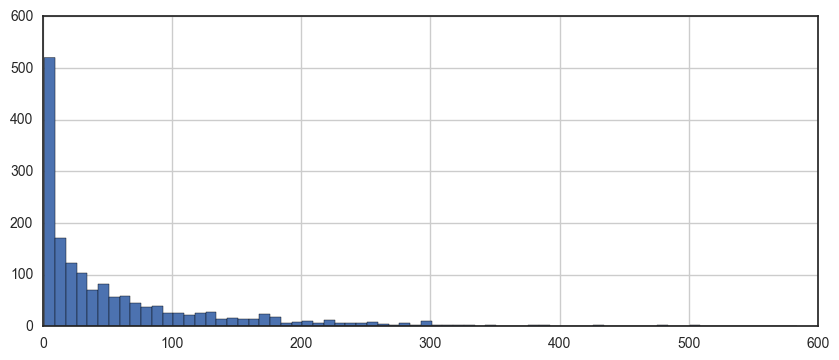

In [15]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

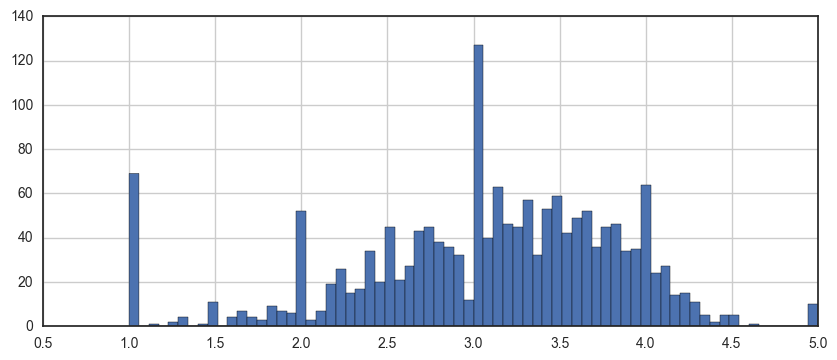

In [23]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

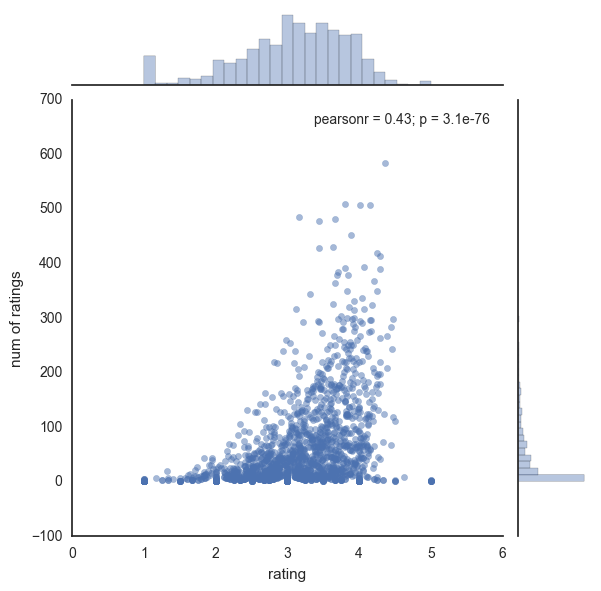

In [31]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

이제 데이터가 어떻게 생겼는지 감이 온다. 이제 간단한 추천 시스템을 만들어 보자.

## 유사한 영화들 추천하기

In [36]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


user_id를 인덱스로 하고 영화의 제목을 한 축으로 하는 행렬을 만들어 보자. 각 셀은 유저가 해당 영화에 대해 주었던 평점에 대한 정보를 갖게 된다. 사람들이 보지 못한 영화들이 많기 때문에 수많은 NaN 값들이 있다는 것을 볼 수 있다.

In [33]:
moviemat = df.pivot_table(index='user_id', columns='title', values = 'rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


가장 평점이 많이 매겨진 영화들:

In [37]:
ratings.sort_values('num of ratings', ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


여기서 두 영화를 선택해 보자: sci-fi 영화인 스타워즈, 그리고 코미디 영화인 Liar Liar이다.

이 두 영화에 대해서 사용자들의 평점을 살펴보자:

In [39]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

두 Pandas 시리즈의 상관관계를 얻기 위해서, corrwith()를 사용할 수 있다:

In [42]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

C:\Users\Sungjin_Lee\Anaconda3\envs\py35\lib\site-packages\numpy\lib\function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Users\Sungjin_Lee\Anaconda3\envs\py35\lib\site-packages\numpy\lib\function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [44]:
similar_to_starwars.head()

title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

NaN 값들을 제거해 주고 DataFrame의 series를 사용하자:

In [45]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


이제 상관관계를 기준으로 분류시, 우리는 가장 유사한 영화들을 찾을 수 있다. 하지만 몇몇 결과는 문제가 있어 보인다. 이는 가장 유명한 영화였던 스타워즈를 본 사용자들에게 한번만 보여진 많은 영화들이 있기 때문이다.

In [46]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


100회 이상의 리뷰를 받은 영화들만 선택하는 조건을 추가하자. 이 100회 라는 값은 앞서 히스토그램에 의해 계산된 것이다.

In [165]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


이제 값들을 조건에 맞게 다시 정렬해서 살펴보자:

In [157]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


코미디 영화인 Liar Liar에 대해서도 적용해 보자:

In [47]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137


# 참 잘했어요!